<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_03_06_survival_analysis_gompertz_model_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 3.6 Gompertz Survival Model


The Gompertz survival model is less commonly used but is particularly effective for modeling scenarios where the hazard rate increases exponentially over time. This makes it suitable for applications such as modeling mortality rates in aging populations or disease progression where risk accumulates rapidly.



## Overview


The **Gompertz survival model** is a parametric model used in survival analysis to model time-to-event data, particularly when the hazard rate increases exponentially over time. It is widely used in fields like actuarial science, demography, and medical research (e.g., modeling mortality or disease progression) due to its ability to capture increasing hazard rates, such as those associated with aging or disease progression. The Gompertz model is part of the Accelerated Failure Time (AFT) framework in some implementations, but it is more commonly parameterized in terms of its hazard function, especially in R’s `flexsurv` package.


### Key Features


- **Hazard Function**: The Gompertz model assumes an exponentially increasing hazard rate, $h(t) = \lambda e^{\gamma t}$, where the hazard grows rapidly over time, making it suitable for processes like aging where risk accumulates.
- **Applications**: Used in mortality studies (e.g., human or animal lifespans), cancer progression, and reliability engineering for systems with increasing failure rates.
- **Assumptions**: Assumes the hazard increases exponentially, driven by the shape parameter $\gamma$. The model is less flexible than the generalized gamma but simpler than models with non-monotonic hazards (e.g., log-normal, log-logistic).
- **Advantages**: Simple parameterization, captures increasing hazards well, and has closed-form expressions for survival and hazard functions.
- **Limitations**: Cannot model decreasing or non-monotonic hazards (use log-normal or generalized gamma instead). May not fit data with complex hazard shapes.


The Gompertz distribution is defined by two parameters:

- $\lambda > 0$: Scale parameter, representing the baseline hazard at $t = 0$.
- $\gamma > 0$: Shape parameter, controlling the rate of hazard increase (for $\gamma = 0$, it reduces to the exponential model).

- **Hazard Function**:

$$
  h(t) = \lambda e^{\gamma t}, \quad t > 0
$$
  The hazard increases exponentially with time, reflecting accelerating risk.

- **Cumulative Hazard Function**:

$$
  H(t) = \int_0^t h(u) \, du = \int_0^t \lambda e^{\gamma u} \, du = \frac{\lambda}{\gamma} (e^{\gamma t} - 1)
$$
- **Survival Function**:

$$
  S(t) = e^{-H(t)} = \exp\left( -\frac{\lambda}{\gamma} (e^{\gamma t} - 1) \right)
$$
- **Probability Density Function (PDF)**:
$$
  f(t) = h(t) S(t) = \lambda e^{\gamma t} \exp\left( -\frac{\lambda}{\gamma} (e^{\gamma t} - 1) \right)
$$

- **Mean**: The mean survival time is complex and involves integrals not expressible in closed form, but it can be computed numerically.


### When to Use


Choose the Gompertz model when:
- Nonparametric hazard estimates (e.g., from Kaplan-Meier or kernel smoothing) show a monotonically increasing hazard.
- The data reflects processes like aging or disease progression where risk grows over time.
- You need a model with a simple, interpretable hazard function and closed-form survival probabilities.


### Model Fit Assessment


- Use AIC/BIC to compare with other models (e.g., Weibull, log-normal).
- Check residuals (e.g., Cox-Snell) or compare fitted survival curves to Kaplan-Meier estimates.
- Validate the increasing hazard assumption with hazard plots or log-cumulative hazard plots.


## Cheeck and Load Required Packages

In [1]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'scikit-survival', 'lifelines']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
Installing scikit-survival...
Failed to install scikit-survival: No module named 'scikit-survival'
Error with package scikit-survival: No module named 'scikit-survival'
Installing lifelines...
lifelines installed successfully
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✗ scikit-survival
✓ lifelines


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.special import expit  # not needed here, but useful for stability

from lifelines import GeneralizedGammaFitter, WeibullFitter
from lifelines.utils import concordance_index
from lifelines.plotting import add_at_risk_counts

## Implementation in Python

### Data Preparation

In [3]:
# Load and prepare data (re-run to ensure T, E, X, n, p are defined in this scope)
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/lung_dataset.csv"
df = pd.read_csv(url)
df['sex'] = df['sex'].map({1: 0, 2: 1})
df['event'] = (df['status'] == 2).astype(int)
df_clean = df.dropna(subset=['time', 'age', 'sex', 'ph.ecog', 'wt.loss']).copy()
df_clean['age_centered'] = df_clean['age'] - df_clean['age'].mean()

T = df_clean['time'].values
E = df_clean['event'].values
X = df_clean[['age_centered', 'sex', 'ph.ecog', 'wt.loss']].values
n, p = X.shape

### Fit Gompertz Model

Since lifelines doesn’t support Gompertz regression, we can define the log-likelihood of the Gompertz model with covariates and maximize it using numerical optimization (e.g., scipy.optimize.minimize).

This is more advanced but gives you a true Gompertz proportional hazards (PH) model with covariates.

In [8]:
# Add column of ones for intercept (optional, but we'll include it in beta)
# We'll estimate: [log_lambda, gamma, beta_0, beta_1, ..., beta_p]
# But it's more stable to estimate log_lambda and log_gamma to enforce positivity

def neg_log_likelihood(params, T, E, X):
    """
    Negative log-likelihood for Gompertz PH model.
    params = [log_lambda, log_gamma, beta_0, beta_1, ..., beta_{p-1}]
    """
    log_lambda = params[0]
    log_gamma = params[1]
    beta = params[2:]

    lambda_ = np.exp(log_lambda)
    gamma = np.exp(log_gamma)  # ensures gamma > 0

    # Linear predictor
    xb = X @ beta  # shape (n,)

    # First term: sum of log hazard for events
    term1 = np.sum(E * (log_lambda + gamma * T + xb))

    # Second term: cumulative hazard integral
    # H(t) = (lambda * exp(xb) / gamma) * (exp(gamma * t) - 1)
    cum_hazard = (lambda_ * np.exp(xb) / gamma) * (np.exp(gamma * T) - 1)
    term2 = np.sum(cum_hazard)

    # Return negative log-likelihood
    return -(term1 - term2)

# Initial guess
initial_params = np.array([np.log(0.01), np.log(0.01)] + [0.0] * p)

# Optimize
result = minimize(
    neg_log_likelihood,
    initial_params,
    args=(T, E, X),
    method='L-BFGS-B'
)

if not result.success:
    print("Optimization failed:", result.message)

In [5]:
# Extract estimates
log_lambda_hat, log_gamma_hat = result.x[0], result.x[1]
beta_hat = result.x[2:]
lambda_hat = np.exp(log_lambda_hat)
gamma_hat = np.exp(log_gamma_hat)

print(f"Estimated λ (scale): {lambda_hat:.6f}")
print(f"Estimated γ (shape): {gamma_hat:.6f}")
print("\nCovariate log-hazard ratios (β):")
for i, col in enumerate(['age_centered', 'sex', 'ph.ecog', 'wt.loss']):
    print(f"  {col}: {beta_hat[i]:.4f}")

Estimated λ (scale): 0.001205
Estimated γ (shape): 0.001685

Covariate log-hazard ratios (β):
  age_centered: 0.0119
  sex: -0.5568
  ph.ecog: 0.5027
  wt.loss: -0.0077


In [ ]:
# Compute standard errors via inverse Hessian (observed Fisher info)
try:
    cov_matrix = np.linalg.inv(result.hess_inv.todense())
    se = np.sqrt(np.diag(cov_matrix))
    print("\nStandard errors:")
    for i, col in enumerate(['age_centered', 'sex', 'ph.ecog', 'wt.loss']):
        print(f"  {col}: {se[2+i]:.4f}")
except Exception as e:
    print("Could not compute standard errors:", e)


Standard errors:
  age_centered: 48.9118
  sex: 5.3059
  ph.ecog: 10.3720
  wt.loss: 187.6061


### Predictions and Survival Estimates

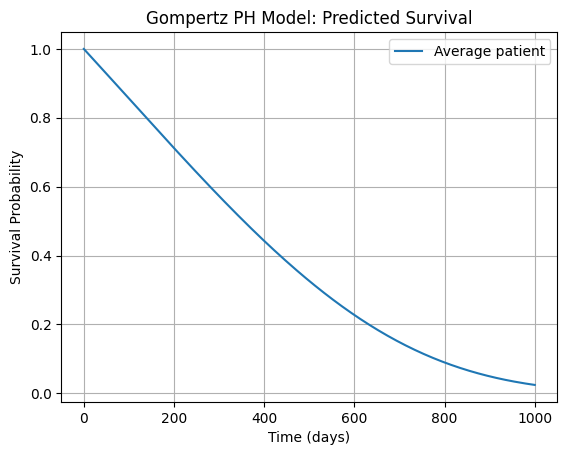

In [9]:
def survival_function(t, x, lambda_, gamma, beta):
    xb = np.dot(x, beta)
    H = (lambda_ * np.exp(xb) / gamma) * (np.exp(gamma * t) - 1)
    return np.exp(-H)

# Example: average patient
x_avg = np.array([0, 0.5, df_clean['ph.ecog'].median(), df_clean['wt.loss'].median()])

times = np.linspace(0, 1000, 200)
surv = [survival_function(t, x_avg, lambda_hat, gamma_hat, beta_hat) for t in times]

plt.plot(times, surv, label='Average patient')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.title('Gompertz PH Model: Predicted Survival')
plt.legend()
plt.grid(True)
plt.show()

## Summary and Conclusion


The Gompertz survival model is a powerful tool for modeling time-to-event data with exponentially increasing hazard rates. It is particularly useful in contexts such as aging populations and disease progression, where risk accumulates rapidly over time. By leveraging the `flexsurv` package in R, we can effectively fit Gompertz models, make predictions, and assess model fit through various diagnostic plots.
When applying the Gompertz model, it is crucial to ensure that the data meets the model's assumptions, particularly the increasing hazard rate. Model diagnostics, including log-cumulative hazard plots and Cox-Snell residuals, help validate these assumptions and assess the model's adequacy.


## Resources


- **R Documentation**:
  - `survreg`: [https://rdrr.io/r/stats/survreg.html](https://rdrr.io/r/stats/survreg.html)
  - `flexsurvreg`: [https://cran.r-project.org/web/packages/flexsurv/flexsurv.pdf](https://cran.r-project.org/web/packages/flexsurv/flexsurv.pdf)
- **Books**:
  - "Survival Analysis: Techniques for Censored and Truncated Data" by Klein & Moeschberger
  - "Applied Survival Analysis" by Hosmer, Lemeshow, & May
- **Tutorials**:
  - UCLA IDRE Survival Analysis with R: [https://stats.idre.ucla.edu/r/seminars/survival-analysis-with-r/](https://stats.idre.ucla.edu/r/seminars/survival-analysis-with-r/)
  - R-bloggers: [https://www.r-bloggers.com/](https://www.r-bloggers.com/)
- **Online Courses**:
  - Coursera: "Survival Analysis in R" by Duke University
  - edX: "Survival Analysis" by Harvard University

